In [113]:
# Standard Libraries
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Scikit-Learn Components
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, mean_squared_error,
    root_mean_squared_error, make_scorer
)
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_validate, cross_val_predict
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint

In [114]:
data_path = Path("DATA/wdbc.data")
if data_path.exists():
    # Define column names based on wdbc.names
    columns = ['id', 'diagnosis'] + [
        f"{feat}_{stat}" for feat in [
            "radius", "texture", "perimeter", "area", "smoothness", "compactness",
            "concavity", "concave_points", "symmetry", "fractal_dimension"
        ] for stat in ["mean", "se", "worst"]
    ]
    df = pd.read_csv(data_path, header=None, names=columns)
    df.drop(columns=['id'], inplace=True)
    
    # Map diagnosis: M = 1 (malignant), B = 0 (benign)
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
    print("Loaded WDBC data from wdbc.data")


# Quick check
print(f"Dataset shape: {df.shape}")
print("Class distribution (0=benign, 1=malignant):")

benign_count = df["diagnosis"].value_counts()[0]
benign_perc = round(100*benign_count/df.shape[0], 2)

malignant_count = df["diagnosis"].value_counts()[1]
malignant_perc = round(100*malignant_count/df.shape[0], 2)

data_description = {
    "Attribute": [
        "Sample Total",
        "Dimensionality",
        "Classes",
        "Sample per class"
    ],
    "Number of Attributes": [
        df.shape[0],
        df.shape[1]-1, #without considering the labels
        2,
        f"Benign: {benign_count} ({benign_perc}%)\nMalignant: {malignant_count} ({malignant_perc}%)"
    ]
}

# Convert to DataFrame
description_df = pd.DataFrame(data_description)
description_df.style.set_properties(
    **{
        "text-align": "center",
        "white-space": "pre-wrap"
    }
).set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]}
]).hide(axis="index")

Loaded WDBC data from wdbc.data
Dataset shape: (569, 31)
Class distribution (0=benign, 1=malignant):


Attribute,Number of Attributes
Sample Total,569
Dimensionality,30
Classes,2
Sample per class,Benign: 357 (62.74%) Malignant: 212 (37.26%)


In [115]:
# Separate features and target
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

malignant = np.array([np.sum(y_train==1), np.sum(y_test==1), np.sum(y_train==1)+np.sum(y_test==1)])
benign = np.array([np.sum(y_train==0), np.sum(y_test==0), np.sum(y_train==0)+np.sum(y_test==0)])
sizes = np.array([y_train.shape[0], y_test.shape[0], y.shape[0]])

# Properly pair values with percentages using zip
data_description = {
    "Dataset": [
        "Training set",
        "Testing set",
        "Total data"
    ],
    "Malignant": [
        f"{value} ({round(perc, 2)}%)" for value, perc in zip(malignant, 100 * malignant / sizes)
    ],
    "Benign": [
        f"{value} ({round(perc, 2)}%)" for value, perc in zip(benign, 100 * benign / sizes)
    ],
    "Total Data": sizes,
}

# Convert to DataFrame
description_df = pd.DataFrame(data_description)
description_df.style.set_properties(
    **{
        "text-align": "center",
        "white-space": "pre-wrap"
    }
).set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]}
]).hide(axis="index")

Dataset,Malignant,Benign,Total Data
Training set,170 (37.36%),285 (62.64%),455
Testing set,42 (36.84%),72 (63.16%),114
Total data,212 (37.26%),357 (62.74%),569


In [116]:
# Models to compare
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        self.model = LinearRegression()
        self.threshold = threshold
    def fit(self, X, y):
        self.model.fit(X, y)
        # Define classes_ attribute for compatibility
        self.classes_ = np.unique(y)
        return self
    def predict(self, X):
        cont = self.model.predict(X)
        return (cont >= self.threshold).astype(int)
    def decision_function(self, X):
        return self.model.predict(X)

In [117]:
# Scoring metrics
def neg_rmse(y_true, y_pred):
    return -root_mean_squared_error(y_true, y_pred)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'neg_RMSE': make_scorer(neg_rmse),
}

def recall_with_accuracy_constraint(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    per = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return rec if acc > 0.93 and per> 0.90 else 0  # Zero score if accuracy is too low
linear_scorer = make_scorer(recall_with_accuracy_constraint)

def get_metrics(name, results):
    metrics = {
        "Model": name,
        "Accuracy Mean": np.round(np.mean(results['test_accuracy']), 4),
        "Precision Mean": np.round(np.mean(results['test_precision']), 4),
        "Recall Mean": np.round(np.mean(results['test_recall']), 4),
        "F1 Mean": np.round(np.mean(results['test_f1']), 4),
        "AUC Mean": np.round(np.mean(results['test_roc_auc']), 4),
        "RMSE Mean": -np.round(np.mean(results['test_neg_RMSE']), 4),
        "Accuracy Std" : np.round(np.std(results['test_accuracy']), 4),
        "Precision Std" : np.round(np.std(results['test_precision']), 4),
        "Recall Std": np.round(np.std(results['test_recall']), 4),
        "F1 Std": np.round(np.std(results['test_f1']), 4),
        "AUC Std": np.round(np.std(results['test_roc_auc']), 4),
        "RMSE Std": -np.round(np.std(results['test_neg_RMSE']), 4),
    }
    return metrics


    
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000, random_state=42)),
    ("SVM (RBF)", SVC(kernel='rbf', probability=True, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
]


In [118]:
# Performing cross validation on models
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_list = []

# cross validation for classification models
for name, model in models:
    pipeline = make_pipeline(MinMaxScaler(), model)
    cv_res = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
    metrics = get_metrics(name, cv_res)
    cv_results_list.append(metrics)

# manual cross validation for linear regression classifier
pipeline = Pipeline([('scaler', MinMaxScaler()), ('linreg_clf', LinearRegressionClassifier())])
acc_list, prec_list, rec_list, f1_list, auc_list, rmse_list = [], [], [], [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_tr, X_te = X_train[train_index], X_train[test_index]
    y_tr, y_te = y_train[train_index], y_train[test_index]
    
    fold_pipe = clone(pipeline)
    fold_pipe.fit(X_tr, y_tr)
    
    y_te_scores = fold_pipe.decision_function(X_te)
    y_te_pred = fold_pipe.predict(X_te)
    
    acc_list.append(accuracy_score(y_te, y_te_pred))
    prec_list.append(precision_score(y_te, y_te_pred))
    rec_list.append(recall_score(y_te, y_te_pred))
    f1_list.append(f1_score(y_te, y_te_pred))
    auc_list.append(roc_auc_score(y_te, y_te_scores))
    rmse_list.append(np.sqrt(mean_squared_error(y_te, y_te_pred)))

metrics = get_metrics("LinearRegressionClassifier", {'test_accuracy': acc_list, 'test_precision': prec_list, 'test_recall': rec_list,
                       'test_f1': f1_list, 'test_roc_auc': auc_list, 'test_neg_RMSE': list(map(lambda x: -x, rmse_list))})
cv_results_list.append(metrics)

In [119]:
cv_results_df = pd.DataFrame(cv_results_list)
cv_results_df.index = cv_results_df.index + 1  # start index from 1
cv_results_df

,Model,Accuracy Mean,Precision Mean,Recall Mean,F1 Mean,AUC Mean,RMSE Mean,Accuracy Std,Precision Std,Recall Std,F1 Std,AUC Std,RMSE Std
1,Logistic Regression,0.9627,0.9941,0.9059,0.9459,0.9911,0.1586,0.0296,0.0176,0.0798,0.0441,0.0150,-0.1102
2,SVM (RBF),0.9714,0.9764,0.9471,0.9597,0.9917,0.1155,0.0357,0.0375,0.0809,0.0516,0.0154,-0.1233
3,Random Forest,0.9626,0.9635,0.9353,0.9484,0.9901,0.1466,0.0355,0.0398,0.0668,0.0491,0.0127,-0.1262
4,K-Nearest Neighbors,0.9691,0.9857,0.9294,0.9554,0.9850,0.1157,0.0467,0.0429,0.0941,0.0680,0.0249,-0.1324
5,LinearRegressionClassifier,0.9539,0.9923,0.8824,0.9328,0.9940,0.1949,0.0350,0.0231,0.0789,0.0530,0.0086,-0.0902


Tuning Logistic Regression with RandomizedSearchCV...
Best params for Logistic Regression: {'logisticregression__C': np.float64(2.481040974867813), 'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2'}
Tuning Random Forest with RandomizedSearchCV...
Best params for Random Forest: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 187}
Tuning K-Nearest Neighbors with RandomizedSearchCV...
Best params for K-Nearest Neighbors: {'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Tuning SVM (RBF) with RandomizedSearchCV...
Best params for SVM (RBF): {'svc__C': np.float64(57.27904470799624), 'svc__gamma': np.float64(0.04835952776465952)}
Tuning LinearRegressionClassifier with RandomizedSearchCV...
Best params for LinearRegressionCla

,Model,Accuracy,Precision,Recall,F1,AUC,RMSE
1,Logistic Regression,0.9825,1.000,0.9524,0.9756,0.9980,0.1325
2,Random Forest,0.9737,1.000,0.9286,0.9630,0.9944,0.1622
3,K-Nearest Neighbors,0.9649,0.975,0.9286,0.9512,0.9856,0.1873
4,SVM (RBF),0.9912,1.000,0.9762,0.9880,0.9964,0.0937
5,LinearRegressionClassifier,0.9825,1.000,0.9524,0.9756,0.9970,0.1325


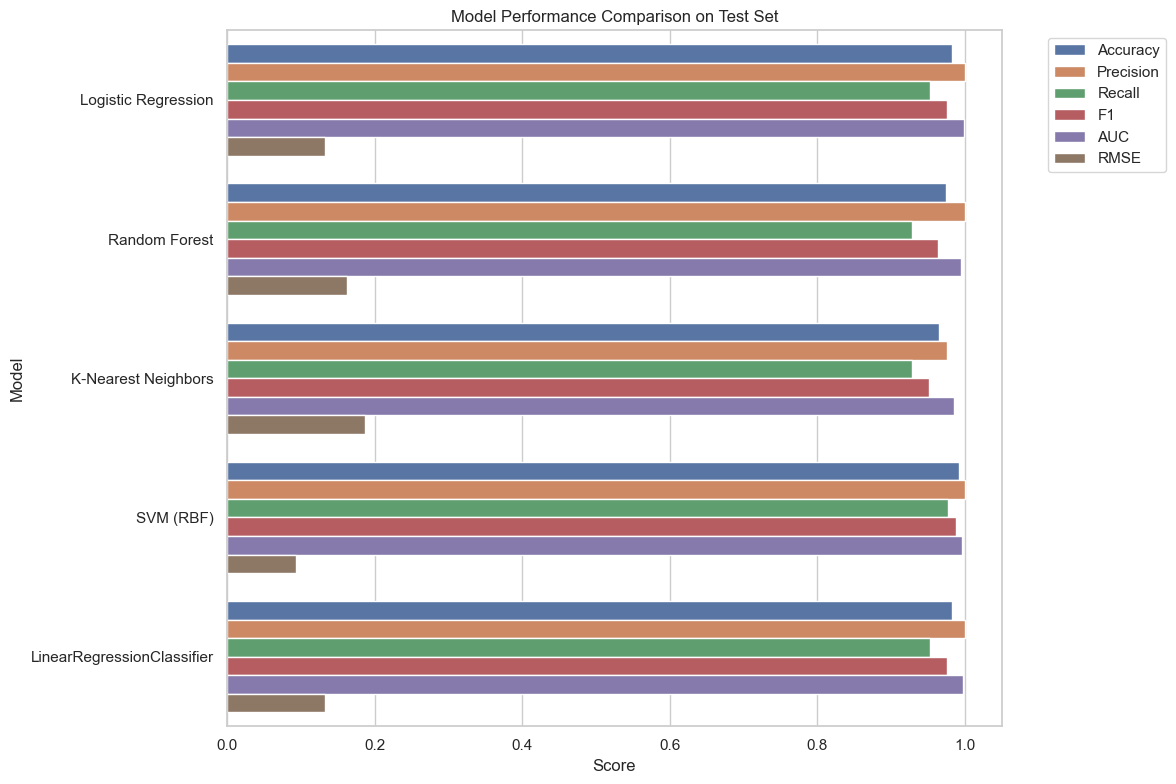

In [ ]:
# Define the models including the custom classifier
models = [
    ["Logistic Regression", LogisticRegression(max_iter=10000, random_state=42)],
    ["Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)],
    ["K-Nearest Neighbors", KNeighborsClassifier()],
    ["SVM (RBF)", SVC(kernel='rbf', probability=True, random_state=42)],
    ["LinearRegressionClassifier", LinearRegressionClassifier()]
]

param_grids = {
    "SVM (RBF)": {
        'svc__C': loguniform(1e-2, 1e2),
        'svc__gamma': loguniform(1e-4, 1e-1)
    },
    "LinearRegressionClassifier": {
        'linearregressionclassifier__threshold': uniform(loc=0.3, scale=0.25)
    },
    "K-Nearest Neighbors": {
        'kneighborsclassifier__n_neighbors': randint(1, 30),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__p': [1, 2],
    },
    "Random Forest" : {
        'randomforestclassifier__n_estimators': randint(100, 300),
        'randomforestclassifier__max_depth': [None, 10, 20, 30, 50],
        'randomforestclassifier__min_samples_split': randint(2, 10),
        'randomforestclassifier__min_samples_leaf': randint(1, 5),
        'randomforestclassifier__max_features': ['sqrt', 'log2', None]
    },
    "Logistic Regression": {
        'logisticregression__C': loguniform(1e-2, 1e2),
        'logisticregression__penalty': ['l2'],
        'logisticregression__fit_intercept': [True, False],
    }

}

# --- Modified model tuning with multiple metrics tracking ---
logreg_cv_result, svm_cv_result, rf_cv_result = None, None, None
index = -5

# Multi-metric scoring
multi_scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

for name, model in models:
    print(f"Tuning {name} with RandomizedSearchCV...")
    pipeline = make_pipeline(MinMaxScaler(), clone(model))
    param_dist = param_grids.get(name, {})

    if param_dist:
        if name != "LinearRegressionClassifier":
            # Multi-metric for normal models
            random_search = RandomizedSearchCV(
                pipeline,
                param_distributions=param_dist,
                n_iter=30,
                cv=cv,
                scoring=multi_scoring,
                refit='f1',
                random_state=42,
                n_jobs=-1
            )
        else:
            # Single-metric for custom classifier
            random_search = RandomizedSearchCV(
                pipeline,
                param_distributions=param_dist,
                n_iter=30,
                cv=cv,
                scoring=linear_scorer,  # single callable scorer
                refit=True,             # must be bool or scorer name
                random_state=42,
                n_jobs=-1
            )

        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        print(f"Best params for {name}: {random_search.best_params_}")

        if name == "Logistic Regression":
            logreg_cv_result = random_search.cv_results_
        elif name == "SVM (RBF)":
            svm_cv_result = random_search.cv_results_
        elif name == "Random Forest":
            rf_cv_result = random_search.cv_results_
        elif name == "K-Nearest Neighbors":
            knn_cv_result  = random_search.cv_results_ 
    else:
        best_model = pipeline.fit(X_train, y_train)

    models[index][1] = best_model
    index += 1
    
# --- Test set evaluation remains unchanged ---
test_results = []
for name, model in models:
    pipeline = make_pipeline(MinMaxScaler(), model)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    if name == "LinearRegressionClassifier":
        y_scores = pipeline.decision_function(X_test)
    else:
        y_scores = pipeline.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": np.round(accuracy_score(y_test, y_pred), 4),
        "Precision": np.round(precision_score(y_test, y_pred), 4),
        "Recall": np.round(recall_score(y_test, y_pred), 4),
        "F1": np.round(f1_score(y_test, y_pred), 4),
        "AUC": np.round(roc_auc_score(y_test, y_scores), 4),
        "RMSE": np.round(root_mean_squared_error(y_test, y_pred), 4)
    }
    test_results.append(metrics)

test_results_df = pd.DataFrame(test_results)
test_results_df.index = test_results_df.index + 1
print("\nFinal Model Performance on Test Set:")
display(test_results_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=test_results_df.melt(id_vars="Model"),
            x="value", y="Model", hue="variable", orient="h")
plt.title("Model Performance Comparison on Test Set")
plt.xlabel("Score")
plt.xlim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

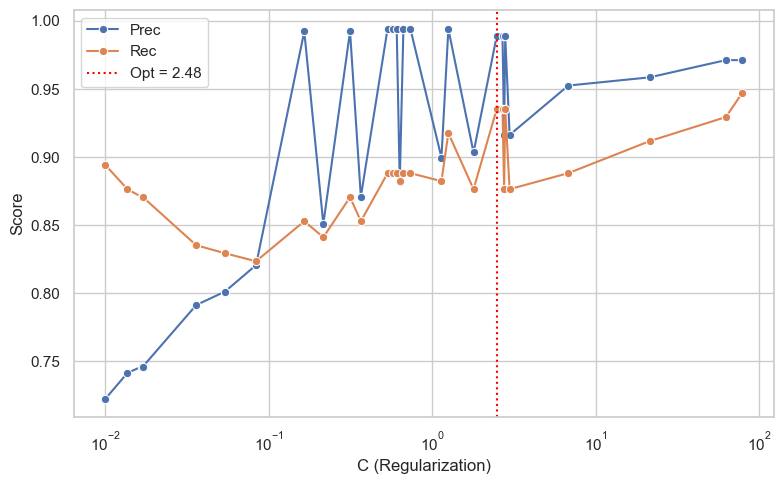

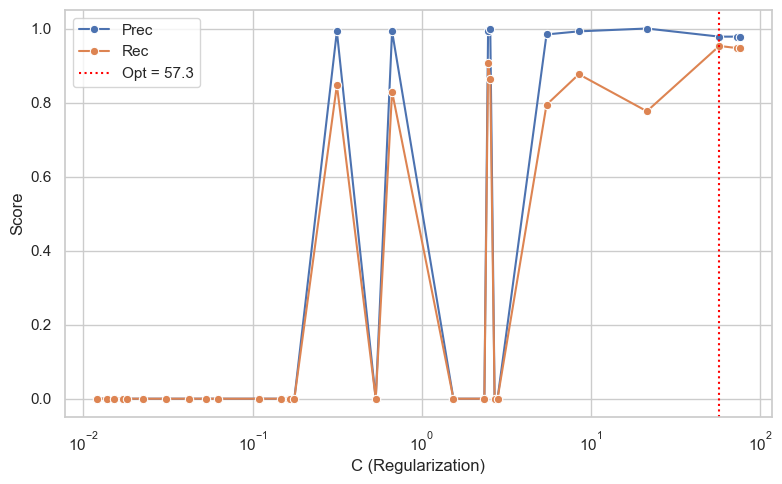

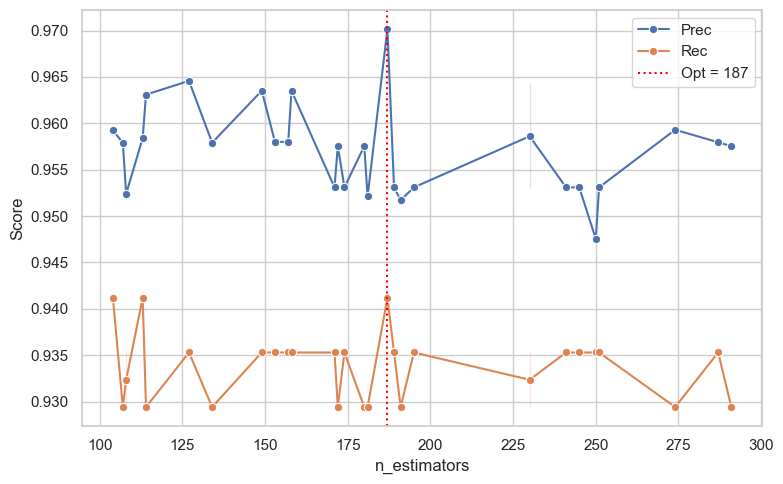

In [ ]:
import matplotlib.ticker as ticker


def plot_prec_recall(cv_results, param_name, chosen_x=None, log_x=False):
    df = pd.DataFrame(cv_results)
    x_vals = df[f'param_{param_name}'].to_numpy()
    precision_vals = df['mean_test_precision'].to_numpy()
    recall_vals = df['mean_test_recall'].to_numpy()

    # Sort for clean plotting
    order = np.argsort(x_vals)
    x_vals = x_vals[order]
    precision_vals = precision_vals[order]
    recall_vals = recall_vals[order]

    # Wider plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=x_vals, y=precision_vals, marker='o', label='Prec')
    sns.lineplot(x=x_vals, y=recall_vals, marker='o', label='Rec')

    # Mark the chosen parameter with a red dotted line
    if chosen_x is not None:
        plt.axvline(x=chosen_x, color='red', linestyle=':', linewidth=1.5,
                    label=f"Opt = {chosen_x:.3g}")

    # Dynamic x-axis label
    if 'C' in param_name:
        plt.xlabel("C (Regularization)")
    elif 'n_estimators' in param_name.lower():
        plt.xlabel("n_estimators")
    else:
        plt.xlabel(param_name)

    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    if log_x:
        plt.xscale('log')
        if 'C' in param_name.lower():
            # Use nice log ticks for C
            ax = plt.gca()
            ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=None))
            ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
            ax.ticklabel_format(style='plain', axis='x')

    plt.tight_layout()
    plt.show()

# Calls
plot_prec_recall(logreg_cv_result, 'logisticregression__C', chosen_x=2.481, log_x=True)
plot_prec_recall(svm_cv_result, 'svc__C', chosen_x=57.279, log_x=True)
plot_prec_recall(rf_cv_result, 'randomforestclassifier__n_estimators', chosen_x=187, log_x=False)
plot_prec_recall(knn_cv_result, 'kneighborsclassifier__n_neighbors', chosen_x=7, log_x=False)